In [1]:
from google.colab import drive
drive.mount('/content/drive/')

DRIVE_ROOT = "/content/drive/My Drive/papers/deepfill"

!cp "/content/drive/My Drive/papers/deepfill/generative-inpainting-pytorch/model/networks.py" ./generative_networks.py
!cp -r "/content/drive/My Drive/papers/deepfill/generative-inpainting-pytorch/utils" .

!cp "/content/drive/My Drive/papers/deepfill/RFR-Inpainting/model.py" ./rfr_model.py
!cp -r "/content/drive/My Drive/papers/deepfill/RFR-Inpainting/modules" .
!cp "/content/drive/My Drive/papers/deepfill/RFR-Inpainting/utils/io.py" ./utils/io.py

!cp "/content/drive/My Drive/papers/deepfill/RN/models.py" ./rn_model.py
!cp "/content/drive/My Drive/papers/deepfill/RN/networks.py" ./networks.py
!cp "/content/drive/My Drive/papers/deepfill/RN/rn.py" ./rn.py

!cp -r "/content/drive/My Drive/papers/deepfill/StructureFlow/src" .
#!cp -r "/content/drive/My Drive/papers/deepfill/StructureFlow/resample2d_package" .

!cp -r "/content/drive/My Drive/papers/deepfill/crfill/networks" ./cr_networks

!cp "/content/drive/My Drive/papers/deepfill/inpainting_gmcnn/pytorch/model/net.py" ./gmcnn_net.py
!cp -r "/content/drive/My Drive/papers/deepfill/inpainting_gmcnn/pytorch/model/" .
!cp -r "/content/drive/My Drive/papers/deepfill/inpainting_gmcnn/pytorch/util/" .

!cp -r "/content/drive/My Drive/papers/deepfill/edge-connect/src/" .

!pip install pytorch-msssim

Mounted at /content/drive/


In [2]:
import os
import torch
import yaml
import numpy as np
from PIL import Image

import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib
import matplotlib.pyplot as plt
from pytorch_msssim import ssim

CUDA = True
device = torch.device("cuda" if CUDA else "cpu")

In [ ]:
#!git -C "/content/drive/My Drive/papers/deepfill/" clone https://github.com/daa233/generative-inpainting-pytorch
#!git -C "/content/drive/My Drive/papers/deepfill/" clone https://github.com/KumapowerLIU/CSA-inpainting
#!git -C "/content/drive/My Drive/papers/deepfill/" clone https://github.com/SayedNadim/Global-and-Local-Attention-Based-Free-Form-Image-Inpainting
# !git -C "/content/drive/MyDrive/papers/deepfill/" clone https://github.com/RenYurui/StructureFlow
#!git -C "/content/drive/My Drive/papers/deepfill/" clone https://github.com/jingyuanli001/RFR-Inpainting
#!git -C "/content/drive/My Drive/papers/deepfill/" clone https://github.com/geekyutao/RN
#!git -C "/content/drive/My Drive/papers/deepfill/" clone https://github.com/zengxianyu/crfill
#!git -C "/content/drive/My Drive/papers/deepfill/" clone https://github.com/JiahuiYu/generative_inpainting

In [3]:
GENERATIVE = 0
RFR = 1
RN = 2
CRFILL = 3
GMCNN = 4
EDGE_CONNECT = 5
PARTIAL_CONV = 6
STRUCTURE_FLOW = 7

img_shape = [256, 256, 3]

def pil_load(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

# GMCNN
class Options:
    def __init__(self):
        self.phase = 'test'
        self.gpu_ids = [0]
        self.model_folder = ""
        self.g_cnum = 32

# EDGE_CONNECT
from skimage.feature import canny
from skimage.color import rgb2gray, gray2rgb
def generate_edge(img, mask):
    mask = (1 - mask).astype(np.bool)
    return canny(img, sigma=2, mask=mask).astype(np.float)

class EC_Config:
    def __init__(self):
        entries = {
            'MODE': 2,                      # 1: train, 2: test, 3: eval
            'MODEL': 4,                     # 1: edge model, 2: inpaint model, 3: edge-inpaint model, 4: joint model
            'MASK': 3,                      # 1: random block, 2: half, 3: external, 4: (external, random block), 5: (external, random block, half)
            'EDGE': 1,                      # 1: canny, 2: external
            'NMS': 1,                       # 0: no non-max-suppression, 1: applies non-max-suppression on the external edges by multiplying by Canny
            'SEED': 10,                     # random seed
            'GPU': [0],                     # list of gpu ids
            'DEBUG': 0,                     # turns on debugging mode
            'VERBOSE': 0,                   # turns on verbose mode in the output console
            'PATH': "",

            'LR': 0.0001,                   # learning rate
            'D2G_LR': 0.1,                  # discriminator/generator learning rate ratio
            'BETA1': 0.0,                   # adam optimizer beta1
            'BETA2': 0.9,                   # adam optimizer beta2
            'BATCH_SIZE': 8,                # input batch size for training
            'INPUT_SIZE': 256,              # input image size for training 0 for original size
            'SIGMA': 2,                     # standard deviation of the Gaussian filter used in Canny edge detector (0: random, -1: no edge)
            'MAX_ITERS': 2e6,               # maximum number of iterations to train the model

            'EDGE_THRESHOLD': 0.5,          # edge detection threshold
            'L1_LOSS_WEIGHT': 1,            # l1 loss weight
            'FM_LOSS_WEIGHT': 10,           # feature-matching loss weight
            'STYLE_LOSS_WEIGHT': 1,         # style loss weight
            'CONTENT_LOSS_WEIGHT': 1,       # perceptual loss weight
            'INPAINT_ADV_LOSS_WEIGHT': 0.01,# adversarial loss weight

            'GAN_LOSS': 'nsgan',            # nsgan | lsgan | hinge
            'GAN_POOL_SIZE': 0,             # fake images pool size

            'SAVE_INTERVAL': 1000,          # how many iterations to wait before saving model (0: never)
            'SAMPLE_INTERVAL': 1000,        # how many iterations to wait before sampling (0: never)
            'SAMPLE_SIZE': 12,              # number of images to sample
            'EVAL_INTERVAL': 0,             # how many iterations to wait before model evaluation (0: never)
            'LOG_INTERVAL': 10,             # how many iterations to wait before logging training status (0: never)
        }

        self.__dict__.update(entries)

# vgg19
from collections import namedtuple

CONTENT_WEIGHT = 1
STYLE_WEIGHTS = np.array([1e-1, 1, 1e1, 5, 1e1]) * 1e4
REGULARIZATION = 1e-6

vgg_model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True).to(device)
vgg_model.eval()
LossOutput = namedtuple("LossOutput", ["relu1", "relu2", "relu3", "relu4", "relu5"])
# https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
class LossNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1",
            '8': "relu2",
            '17': "relu3",
            '26': "relu4",
            '35': "relu5",
        }
    
    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram
def vgg_norm():
    return transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]) 
def vgg_recover(img):
    return (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

loss_network = LossNetwork(vgg_model).to(device)
loss_network.eval()
print("Done loading loss network!")

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Done loading loss network!


In [4]:
# generative-inpainting
from generative_networks import Generator as GENERATIVE_Generator
from utils.tools import normalize
# rfr-inpainting
from rfr_model import RFRNetModel as RFR_Model
from modules.RFRNet import RFRNet
# RN
from rn_model import InpaintingModel as RN_Model
# crfill
from cr_networks.convnet import InpaintGenerator as CR_Model
# gmcnn
from gmcnn_net import InpaintingModel_GMCNN as GMCNN_Model
# edge connect
from src.models import EdgeModel as EC_EdgeModel
from src.models import InpaintingModel as EC_InpaintModel
# StructureFlow
#from src.models import StructureFlowModel


def load_data(image_path, mask_path):
    x    = pil_load(image_path)
    mask = pil_load(mask_path)

    x = transforms.Resize(img_shape[:-1])(x)
    x = transforms.CenterCrop(img_shape[:-1])(x)

    mask = transforms.Resize(img_shape[:-1])(mask)
    mask = transforms.CenterCrop(img_shape[:-1])(mask)

    return x, mask

def normalise(x):
    return x * 2. - 1.

def run(model, x, mask):
  
    if model == GENERATIVE:
        x = transforms.ToTensor()(x).to(device)
        mask = transforms.ToTensor()(mask)[0].unsqueeze(dim=0).to(device)
        x = normalise(x)
        x = x * (1. - mask)
        x = x.unsqueeze(dim=0)
        mask = mask.unsqueeze(dim=0)

        netG = GENERATIVE_Generator({'input_dim': 3, 'ngf': 32}, CUDA, [0])
        netG.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/generative-inpainting-pytorch/imagenet/gen_00430000.pt", map_location=device))

        if CUDA:
            netG = nn.parallel.DataParallel(netG, device_ids=[0])
            x = x.cuda()
            mask = mask.cuda()

        # Inference
        x1, x2, offset_flow = netG(x, mask)
        inpainted_result = x2 * mask + x * (1. - mask)
        # 0 to 1 range
        return (inpainted_result + 1) / 2.

    elif model == RFR:
        rfr_model = RFR_Model()

        rfr_model.G = RFRNet()
        _temp = torch.load(f"{DRIVE_ROOT}/pretrained/RFR-Inpainting/celeba/checkpoint_celeba.pth", map_location=device)
        #_temp = torch.load(f"{DRIVE_ROOT}/pretrained/RFR-Inpainting/places/checkpoint_paris.pth", map_location=device)
        rfr_model.G.load_state_dict(_temp['generator'], strict=False)

        if CUDA:
            rfr_model.cuda()

        rfr_model.G.eval()

        x = transforms.ToTensor()(x).to(device)
        mask = transforms.ToTensor()(mask).to(device)

        x = x * (1. - mask)
        x = x.unsqueeze(dim=0)
        
        mask = mask.unsqueeze(dim=0)

        fake_B, _ = rfr_model.G(x, 1 - mask)

        comp_B = fake_B * mask  + x * (1. - mask)
        # 0 to 1 range
        return torch.clip(comp_B, 0., 1.)
        #return (comp_B - torch.min(comp_B)) / (torch.max(comp_B) - torch.min(comp_B))

    elif model == RN:
        model = RN_Model(g_lr=0.0001, d_lr=0.001, l1_weight=1.0, gan_weight=0.1, iter=0, threshold=0.8)
        pretained_model = torch.load(f"{DRIVE_ROOT}/pretrained/RN/places2/x_admin.cluster.localRN-0.8RN-Net_bs_14_epoch_3.pth", map_location=device)

        if CUDA:
            model = model.cuda()
            model.generator = torch.nn.DataParallel(model.generator, device_ids=[0])
            model.discriminator = torch.nn.DataParallel(model.discriminator, device_ids=[0])
            model.load_state_dict(pretained_model, strict=False)
        else:
            new_state_dict = model.state_dict()
            for k, v in pretained_model.items():
                k = k.replace('module.', '')
                new_state_dict[k] = v
            model.load_state_dict(new_state_dict)

        model.eval()
        model.generator.eval()

        x = transforms.ToTensor()(x).to(device)
        mask = transforms.ToTensor()(mask)[0].unsqueeze(dim=0).to(device)

        x = x * (1. - mask)
        x = x.unsqueeze(dim=0)
        
        mask = mask.unsqueeze(dim=0)

        fake_B = model.generator(x, mask)

        comp_B = fake_B * mask  + x * (1. - mask)
        # 0 to 1 range
        return comp_B

    elif model == CRFILL:
        model = CR_Model()
        model.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/crfill/places2/model_256.pth", map_location=device))
        model.to(device)

        x = transforms.ToTensor()(x).to(device)
        mask = transforms.ToTensor()(mask)[0].unsqueeze(dim=0).to(device)
        x = normalise(x)
        x = x * (1. - mask)
        x = x.unsqueeze(dim=0)
        mask = mask.unsqueeze(dim=0)

        _, result = model(x, mask)

        full_result = result * mask + x * (1. - mask)
        # 0 to 1 range
        return (full_result + 1) / 2.
    
    elif model == GMCNN:

        model = GMCNN_Model(in_channels=4, opt=Options())
        model.load_networks(f"{DRIVE_ROOT}/pretrained/inpainting_gmcnn/celeba/10_net_GM.pth")
        model.to(device)

        x = transforms.ToTensor()(x).to(device)
        mask = transforms.ToTensor()(mask)[0].unsqueeze(dim=0).to(device)
        x = normalise(x)
        x = x * (1. - mask)
        x = x.unsqueeze(dim=0)
        mask = mask.unsqueeze(dim=0)

        # Inference
        x2 = model.netGM(torch.cat((x, mask), 1))
        inpainted_result = x2 * mask + x * (1. - mask)
        # 0 to 1 range
        return (inpainted_result + 1) / 2.
    
    elif model == EDGE_CONNECT:

        edge_model = EC_EdgeModel(EC_Config()).to(device)
        inpaint_model = EC_InpaintModel(EC_Config()).to(device)

        edge_model.generator.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/edge-connect/celeba/EdgeModel_gen.pth", map_location=device)['generator'])
        inpaint_model.generator.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/edge-connect/celeba/InpaintingModel_gen.pth", map_location=device)['generator'])

        grey_x = transforms.ToTensor()(rgb2gray(np.array(x))).to(device)
        x = transforms.ToTensor()(x).to(device)

        mask = transforms.ToTensor()(mask)[0].unsqueeze(dim=0).to(device)
        edge = generate_edge(grey_x[0].cpu().detach().numpy(), mask.squeeze(0).cpu().detach().numpy())
        edge = transforms.ToTensor()(edge).float().to(device).unsqueeze(0)

        x = x * (1. - mask)
        x = x.unsqueeze(dim=0)
        grey_x = grey_x * (1. - mask)
        grey_x = grey_x.float().unsqueeze(dim=0)
        mask = mask.unsqueeze(dim=0)

        edges = edge_model(grey_x, edge, mask).detach()
        outputs = inpaint_model(x, edges, mask)
        outputs_merged = (outputs * mask) + (x * (1 - mask))

        # 0 to 1 range
        return outputs_merged

    elif model == PARTIAL_CONV:
        return None

    elif model == STRUCTURE_FLOW:
        return None
        model = StructureFlowModel(load_config('test')).to(device)

        model.s_gen.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/StructureFlow/places/latest_net_s_gen.pth", map_location=device))
        model.f_gen.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/StructureFlow/places/latest_net_f_gen.pth", map_location=device))

        x = transforms.ToTensor()(x).to(device)
        mask = transforms.ToTensor()(mask)[0].unsqueeze(dim=0).to(device)

        x = x * (1. - mask)
        x = x.unsqueeze(dim=0)
        
        mask = mask.unsqueeze(dim=0)

        # smooth comes from http://www.cse.cuhk.edu.hk/~leojia/projects/texturesep/
        smooth_stage_1 = model.structure_forward(x, smooths, mask)
        outputs, _ = model.flow_forward(x, smooth_stage_1, mask)

        outputs_merged = outputs * mask + x * (1 - mask)

        # 0 to 1 range
        return outputs_merged


def plot_all(name_map, _x, _mask, target, image=None, title=None, mask=None):
    fig=plt.figure(figsize=(15, 15))

    for i in range(9):
        ax = fig.add_subplot(3, 3, i + 1)

        ax.set_title(name_map[i], fontsize=22)
        ax.axis('off')
        if i < 6:
            inpainted_result = run(i, _x, _mask)
            img = inpainted_result[0].permute(1, 2, 0).detach().cpu().numpy()
        #elif i == 6:
        #    img = pil_load(image) if image is not None else _x
        elif i == 6:
            img = pil_load(mask) if mask is not None else _mask
        elif i == 7:
            img = target
        elif i == 8:
            img = _x
        plt.imshow(img)
    if title is not None:
        plt.suptitle(title, fontsize=22)
    plt.show()

def plot_models(name_map, _x, _mask, target, image=None, title=None, mask=None):
    fig=plt.figure(figsize=(8, 13))

    for i in range(6):
        ax = fig.add_subplot(3, 2, i + 1)

        ax.set_title(name_map[i])
        ax.axis('off')
        if i < 6:
            inpainted_result = run(i, _x, _mask)
            img = inpainted_result[0].permute(1, 2, 0).detach().cpu().numpy()
        #elif i == 6:
        #    img = pil_load(image) if image is not None else _x
        elif i == 6:
            img = pil_load(mask) if mask is not None else _mask
        elif i == 7:
            img = target
        elif i == 8:
            img = _x
        plt.imshow(img)
    if title is not None:
        plt.suptitle(title, fontsize=22)
    plt.show()

# from https://stackoverflow.com/questions/48987774/how-to-crop-a-numpy-2d-array-to-non-zero-values
def crop_to_mask(x_img, mask):
    coords = np.argwhere(mask[0].cpu().numpy())
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)
    return x_img[:,:,x_min:x_max+1, y_min:y_max+1]

In [5]:
def run_preloaded_0to1(model_name, model, x, mask):

    if model_name == RFR:
        
        x = x * (1. - mask)

        mask = mask.squeeze()
        mask = torch.stack([mask] * 3)
        mask = mask.unsqueeze(dim=0)

        fake_B, _ = model(x, 1 - mask)

        comp_B = fake_B * mask  + x * (1. - mask)
        # 0 to 1 range
        return torch.clip(comp_B, 0., 1.)

    elif model_name == RN:
        
        x = x * (1. - mask)

        mask = mask.unsqueeze(dim=0)

        fake_B = model(x, mask)

        comp_B = fake_B * mask  + x * (1. - mask)
        # 0 to 1 range
        return comp_B

    elif model_name == EDGE_CONNECT:

        grey_x = transforms.ToTensor()(rgb2gray(x[0].permute(1, 2, 0).cpu().detach().numpy())).to(device)

        edge = generate_edge(grey_x[0].cpu().detach().numpy(), mask.squeeze(0).cpu().detach().numpy())
        edge = transforms.ToTensor()(edge).float().to(device).unsqueeze(0)

        x = x * (1. - mask)
        grey_x = grey_x * (1. - mask)
        grey_x = grey_x.float().unsqueeze(dim=0)

        mask = mask.unsqueeze(dim=0)

        edges = model[0](grey_x, edge, mask).detach()
        outputs = model[1](x, edges, mask)
        outputs_merged = (outputs * mask) + (x * (1 - mask))

        # 0 to 1 range
        return outputs_merged

# pass normalised x in
def run_preloaded_m1to1(model_name, model, x, mask):
  
    if model_name == GENERATIVE:
        
        x = x * (1. - mask)

        mask = mask.unsqueeze(dim=0)

        x1, x2, offset_flow = model(x, mask)
        inpainted_result = x2 * mask + x * (1. - mask)
        # -1 to 1 range
        return inpainted_result

    elif model_name == CRFILL:

        x = x * (1. - mask)

        mask = mask.unsqueeze(dim=0)

        _, result = model(x, mask)

        full_result = result * mask + x * (1. - mask)
        # -1 to 1 range
        return full_result
    
    elif model_name == GMCNN:
        
        x = x * (1. - mask)

        mask = mask.unsqueeze(dim=0)

        x2 = model(torch.cat((x, mask), 1))
        inpainted_result = x2 * mask + x * (1. - mask)
        # -1 to 1 range
        return inpainted_result

In [6]:
import torch.nn.functional as F
from torch.autograd import Variable

# pre-load all models
models = []
netG = GENERATIVE_Generator({'input_dim': 3, 'ngf': 32}, CUDA, [0])
netG.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/generative-inpainting-pytorch/imagenet/gen_00430000.pt", map_location=device))
if CUDA:
    netG = nn.parallel.DataParallel(netG, device_ids=[0])
netG.to(device)
netG.eval()
models.append(netG)
#
rfr_model = RFR_Model()
rfr_model.G = RFRNet()
_temp = torch.load(f"{DRIVE_ROOT}/pretrained/RFR-Inpainting/celeba/checkpoint_celeba.pth", map_location=device)
#_temp = torch.load(f"{DRIVE_ROOT}/pretrained/RFR-Inpainting/places/checkpoint_paris.pth", map_location=device)
rfr_model.G.load_state_dict(_temp['generator'], strict=False)

if CUDA:
    rfr_model.cuda()
rfr_model.G.eval()
models.append(rfr_model.G)
#
rnmodel = RN_Model(g_lr=0.0001, d_lr=0.001, l1_weight=1.0, gan_weight=0.1, iter=0, threshold=0.8)
rnpretained_model = torch.load(f"{DRIVE_ROOT}/pretrained/RN/places2/x_admin.cluster.localRN-0.8RN-Net_bs_14_epoch_3.pth", map_location=device)

if CUDA:
    rnmodel = rnmodel.cuda()
    rnmodel.generator = torch.nn.DataParallel(rnmodel.generator, device_ids=[0])
    rnmodel.discriminator = torch.nn.DataParallel(rnmodel.discriminator, device_ids=[0])
    rnmodel.load_state_dict(rnpretained_model, strict=False)
else:
    new_state_dict = rnmodel.state_dict()
    for k, v in pretained_model.items():
        k = k.replace('module.', '')
        new_state_dict[k] = v
    rnmodel.load_state_dict(new_state_dict)

rnmodel.eval()
rnmodel.generator.eval()
models.append(rnmodel.generator)
#
crmodel = CR_Model()
crmodel.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/crfill/places2/model_256.pth", map_location=device))
crmodel.to(device)
crmodel.eval()
models.append(crmodel)
#
gmcnnmodel = GMCNN_Model(in_channels=4, opt=Options())
gmcnnmodel.load_networks(f"{DRIVE_ROOT}/pretrained/inpainting_gmcnn/celeba/10_net_GM.pth")
gmcnnmodel.to(device)
gmcnnmodel.eval()
gmcnnmodel.netGM.eval()
models.append(gmcnnmodel.netGM)
#
edge_model = EC_EdgeModel(EC_Config()).to(device)
inpaint_model = EC_InpaintModel(EC_Config()).to(device)

edge_model.generator.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/edge-connect/celeba/EdgeModel_gen.pth", map_location=device)['generator'])
inpaint_model.generator.load_state_dict(torch.load(f"{DRIVE_ROOT}/pretrained/edge-connect/celeba/InpaintingModel_gen.pth", map_location=device)['generator'])

edge_model.eval()
inpaint_model.eval()

models.append((edge_model, inpaint_model))
#

Model moved to cuda
initialize network with normal
loading the model from /content/drive/My Drive/papers/deepfill/pretrained/inpainting_gmcnn/celeba/10_net_GM.pth


****
EoT - Mask-Agnostic Malpainting

In [ ]:
import random

image_path = f"{DRIVE_ROOT}/putin_trump.png" # f"{DRIVE_ROOT}/eye.png" 
image_target_path = f"{DRIVE_ROOT}/putin_trump_target.png" #f"{DRIVE_ROOT}/eye.png" 
mask_path  = f"{DRIVE_ROOT}/putin_trump_mask.png" #f"{DRIVE_ROOT}/eye_mask.png" 

#x = pil_load(image_path)
#targ = pil_load(image_target_path)

#mask = pil_load(mask_path)
#mask = transforms.ToTensor()(mask)[0].unsqueeze(dim=0).to(device)

def requires_norm(j):
    return j in [0, 3, 4]
unnorm = lambda x: (x + 1) / 2
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 10 * torch.log10(1 / mse)
def get_total_loss(j, initial, target, norm_target, mask):
    target = target * mask
    norm_target = norm_target * mask
    initial = initial * mask

    with torch.no_grad():
        _style_loss_features = loss_network(target)
        _gram_style = [gram_matrix(y) for y in _style_loss_features]

    colour_loss = COLOUR_WEIGHT * F.mse_loss(initial, norm_target if requires_norm(j) else target)

    # vgg visual loss
    # loss_network only operates on [0, 1] range
    features_full = loss_network(unnorm(initial) if requires_norm(j) else initial)
    features_input = loss_network(target)

    content_loss = CONTENT_WEIGHT * F.mse_loss(features_full[2], features_input[2])

    reg_loss = REGULARIZATION * (
            torch.sum(torch.abs(initial[:, :, :, :-1] - initial[:, :, :, 1:])) + 
            torch.sum(torch.abs(initial[:, :, :-1, :] - initial[:, :, 1:, :])))
    
    style_loss = 0.
    for l, weight in enumerate(STYLE_WEIGHTS):
        gram_s = _gram_style[l]
        gram_y = gram_matrix(features_full[l])
        style_loss += float(weight) * F.mse_loss(gram_y, gram_s.expand_as(gram_y))
    
    return (content_loss + style_loss + reg_loss + colour_loss).item()

COLOUR_WEIGHT = 4.

epsilons = [0.0, 0.05, 0.1, 0.3] #[0.0, 0.03, 0.05, 0.1, 0.2, 0.3]

update_freq = 1

num_masks = 30
import os
if os.path.exists(f"{DRIVE_ROOT}/results/eot_masks.pt"):
    print("Loading EoT existing masks...")
    eot_masks = torch.load(f"{DRIVE_ROOT}/results/eot_masks.pt")
    for m in eot_masks:
        m.to(device)
else:
    eot_masks = []
    for _ in range(num_masks):
        mask = torch.zeros([1]+img_shape[:-1])
        mask = transforms.RandomErasing(p=1, scale=(0.01, 0.1), value=1)(mask)
        mask = mask.to(device)

        eot_masks.append(mask)
    torch.save(eot_masks, f"{DRIVE_ROOT}/results/eot_masks.pt")

def get_eot_losses(x_img, target_img, test_masks, masks, TARGET_MODELS):

    losses = {}
    for imask in test_masks.keys():
        losses[imask] = []
        for _ in range(6):
            losses[imask].append({
                'l2_target': [],
                'loss_target': [],
                'psnr_target': [],
                'ssim_target': [],

                'l2_orig': [],
                'loss_orig': [],
                'psnr_orig': [],
                'ssim_orig': [],
                
                'l2_wouldhave': [],
                'loss_wouldhave': [],
                'psnr_wouldhave': [],
                'ssim_wouldhave': [],

            })

    targ = transforms.ToTensor()(target_img).to(device)
    targ = transforms.Resize(img_shape[:-1])(targ)
    targ = transforms.CenterCrop(img_shape[:-1])(targ)
    
    x = transforms.ToTensor()(x_img).to(device)
    x = transforms.Resize(img_shape[:-1])(x)
    x = transforms.CenterCrop(img_shape[:-1])(x)

    norm_x = normalise(x)

    wouldhave_results = {}
    for imask, mask in test_masks.items():
        wouldhave_results[imask] = []
        for j in range(6):
            model = models[j]
            run_preloaded = run_preloaded_m1to1 if requires_norm(j) else run_preloaded_0to1
            _would = run_preloaded(j, model, (norm_x if requires_norm(j) else x).unsqueeze(dim=0), mask)
            wouldhave_results[imask].append((_would, crop_to_mask(_would.clone(), mask)))

    attack_images = []
    for epsilon in epsilons:
        iters = 1500.0 if epsilon > 0.0 else 1.0
        step = epsilon / 30

        #x = pil_load(image_path)
        x = transforms.ToTensor()(x_img).to(device)
        x = transforms.Resize(img_shape[:-1])(x)
        x = transforms.CenterCrop(img_shape[:-1])(x)
        x = x.unsqueeze(dim=0)
        
        norm_x = normalise(x)

        _x = x.clone()
        _norm_x = norm_x.clone()

        i = 0

        upper = torch.clamp(x + epsilon, min=0, max=1)
        lower = torch.clamp(x - epsilon, min=0, max=1)

        norm_upper = torch.clamp(norm_x + epsilon, min=-1, max=1)
        norm_lower = torch.clamp(norm_x - epsilon, min=-1, max=1)
        
        while i < iters:
            # cycle through masks
            if (i % update_freq) == 0:      
                mask = random.choice(masks)

                target = (targ * mask + x * (1. - mask))
                norm_target = normalise(target.clone())

                # calculate gram matrices of style image (target in this case)
                with torch.no_grad():
                    style_loss_features = loss_network(target)
                    gram_style = [gram_matrix(y) for y in style_loss_features]

            i += 1

            cumulative_datagrad = None
            for j in TARGET_MODELS:
                model = models[j]

                var_x = Variable(norm_x if requires_norm(j) else x, requires_grad=True)

                if var_x.grad is not None:
                    var_x.grad.data.zero_()

                var_x.retain_grad()
                run_preloaded = run_preloaded_m1to1 if requires_norm(j) else run_preloaded_0to1
                full_result = run_preloaded(j, model, var_x, mask)

                colour_loss = COLOUR_WEIGHT * F.mse_loss(full_result, norm_target if requires_norm(j) else target)

                # vgg visual loss
                # loss_network only operates on [0, 1] range
                features_full = loss_network(unnorm(full_result) if requires_norm(j) else full_result)
                features_input = loss_network(target)

                content_loss = CONTENT_WEIGHT * F.mse_loss(features_full[2], features_input[2])

                reg_loss = REGULARIZATION * (
                        torch.sum(torch.abs(full_result[:, :, :, :-1] - full_result[:, :, :, 1:])) + 
                        torch.sum(torch.abs(full_result[:, :, :-1, :] - full_result[:, :, 1:, :])))
                
                style_loss = 0.
                for l, weight in enumerate(STYLE_WEIGHTS):
                    gram_s = gram_style[l]
                    gram_y = gram_matrix(features_full[l])
                    style_loss += float(weight) * F.mse_loss(gram_y, gram_s.expand_as(gram_y))
                
                total_loss = content_loss + style_loss + reg_loss + colour_loss

                # if i % 30 == 0:
                #     print(i, total_loss)
                if type(model) is not tuple:
                    model.zero_grad()
                else:
                    for m in model:
                        m.zero_grad()
                total_loss.backward()

                # Collect datagrad; add noise
                data_grad = var_x.grad.data.sign() * torch.cuda.FloatTensor(*(var_x.grad.data.shape)).uniform_() * step

                # Sum datagrads from models in loop
                if cumulative_datagrad is None:
                    cumulative_datagrad = data_grad
                else:
                    cumulative_datagrad += data_grad

            x = (x - (cumulative_datagrad[0] * (1 - mask)))
            x = torch.max(torch.min(x, upper), lower)
            norm_x = (norm_x - (cumulative_datagrad[0] * (1 - mask)))
            norm_x = torch.max(torch.min(norm_x, norm_upper), norm_lower)

            #attack_img = x.clone().squeeze().permute(1, 2, 0).detach().cpu().numpy()

        # finished pounding x
        # plt.imshow(attack_img)
        # plt.show()

        #attack_images.append(attack_img)
        # infer attack image on all models
        for imask, mask in test_masks.items():
            target = (targ * mask + x * (1. - mask))
            norm_target = normalise(target.clone())

            target_cropped = crop_to_mask(target, mask)
            norm_target_cropped = crop_to_mask(norm_target, mask)

            c_x = crop_to_mask(_x.clone(), mask)
            c_norm_x = crop_to_mask(_norm_x.clone(), mask)

            for j in range(6):
                model = models[j]
                var_x = norm_x if requires_norm(j) else x

                run_preloaded = run_preloaded_m1to1 if requires_norm(j) else run_preloaded_0to1
                _full_result = run_preloaded(j, model, var_x, mask)
                full_result = crop_to_mask(_full_result.clone(), mask)

                losses[imask][j]['l2_target'].append(F.mse_loss(full_result, (norm_target_cropped if requires_norm(j) else target_cropped)).item())
                losses[imask][j]['loss_target'].append(get_total_loss(j, _full_result, target, norm_target, mask))

                losses[imask][j]['l2_orig'].append(F.mse_loss(full_result, (c_norm_x if requires_norm(j) else c_x)).item())
                losses[imask][j]['loss_orig'].append(get_total_loss(j, _full_result, _x, _norm_x, mask))

                losses[imask][j]['l2_wouldhave'].append(F.mse_loss(full_result, wouldhave_results[imask][j][1]).item())
                losses[imask][j]['loss_wouldhave'].append(get_total_loss(j, _full_result,\
                      wouldhave_results[imask][j][0] if not requires_norm(j) else unnorm(wouldhave_results[imask][j][0]), wouldhave_results[imask][j][0] if requires_norm(j) else normalise(wouldhave_results[imask][j][0]), mask))

                losses[imask][j]['ssim_target'].append(ssim(full_result, (norm_target_cropped if requires_norm(j) else target_cropped), data_range=1).item())
                losses[imask][j]['ssim_orig'].append(ssim(full_result, (c_norm_x if requires_norm(j) else c_x), data_range=1).item())
                losses[imask][j]['ssim_wouldhave'].append(ssim(full_result, wouldhave_results[imask][j][1], data_range=1).item())

                losses[imask][j]['psnr_target'].append(psnr(full_result, (norm_target_cropped if requires_norm(j) else target_cropped)).item())
                losses[imask][j]['psnr_orig'].append(psnr(full_result, (c_norm_x if requires_norm(j) else c_x)).item())
                losses[imask][j]['psnr_wouldhave'].append(psnr(full_result, wouldhave_results[imask][j][1]).item())

    return losses

Loading EoT existing masks...


In [ ]:
def gen_random_mask(size):
    mask = torch.zeros([1]+img_shape[:-1])
    mask = transforms.RandomErasing(p=1, scale=(size, size), value=1)(mask)
    return mask.to(device)

import os
if os.path.exists(f"{DRIVE_ROOT}/results/masks.pt"):
    print("Loading existing masks...")
    test_masks = torch.load(f"{DRIVE_ROOT}/results/masks.pt")
    for m in test_masks.values():
        m.to(device)
    #os.remove(f"{DRIVE_ROOT}/results/masks.pt")
else:
    test_masks = {
        'small': gen_random_mask(0.025),
        'medium': gen_random_mask(0.05),
        'large': gen_random_mask(0.1)
    }
    torch.save(test_masks, f"{DRIVE_ROOT}/results/masks.pt")

test_targets = {
    'red': Image.new("RGB", img_shape[:-1], (255, 0, 0)),
    'green': Image.new("RGB", img_shape[:-1], (0, 255, 0)),
    'blue': Image.new("RGB", img_shape[:-1], (0, 0, 255)),
}

test_dataset = ["Places365_val_00022157.jpg", "Places365_val_00007036.jpg", "Places365_val_00004744.jpg", "Places365_val_00008929.jpg", "Places365_val_00035600.jpg", "Places365_val_00034866.jpg", "Places365_val_00027302.jpg", "Places365_val_00024241.jpg", "Places365_val_00011816.jpg", "Places365_val_00005950.jpg", "Places365_val_00021586.jpg", "Places365_val_00020222.jpg", "Places365_val_00035282.jpg", "Places365_val_00003607.jpg", "Places365_val_00019799.jpg", "Places365_val_00000859.jpg"]

test_images = {}
for im in test_dataset:
    test_images[im] = pil_load(f"{DRIVE_ROOT}/places_subset16/{im}")

#test_images = {
#    'flower': pil_load(f"{DRIVE_ROOT}/results/flower.png"),
#    'eye': pil_load(f"{DRIVE_ROOT}/results/eye.png"),
#    'tram': pil_load(f"{DRIVE_ROOT}/results/vienna_tram.png"),
#    'window': pil_load(f"{DRIVE_ROOT}/results/window.png"),
#}

Loading existing masks...


In [ ]:
name_map = ["GENERATIVE", "RFR", "RN", "CRFILL", "GMCNN", "EDGE CONNECT"]
results = {}
for img in test_images.keys():
    results[img] = {}
    for target in test_targets.keys():
        results[img][target] = {}
        for mask in test_masks.keys():
            results[img][target][mask] = {}
            for model_name in name_map:
                results[img][target][mask][model_name] = []

In [ ]:
import json

if os.path.exists(f"{DRIVE_ROOT}/results/eot_places_subset16.json"):
    print("Loading existing results file...")
    results = json.load(open(f"{DRIVE_ROOT}/results/eot_places_subset16.json"))

def check_need_to_run(ix, itarg, imn, res):
    for imask in test_masks.keys():
        if len(res[ix][itarg][imask][name_map[imn]]) == 0:
            return True
    return False

for ix, x in test_images.items():
    for itarg, targ in test_targets.items():
        for model_n in range(6):
            if check_need_to_run(ix, itarg, model_n, results):
                        # x_img, target_img, test_masks, masks, TARGET_MODELS
                losses = get_eot_losses(x, targ, test_masks, eot_masks, [model_n])
                for imask in test_masks.keys():
                    results[ix][itarg][imask][name_map[model_n]] = losses[imask]
                # save after each target is done
                print(f"Done with {ix}, {itarg}, {name_map[model_n]}")
                with open(f"{DRIVE_ROOT}/results/eot_places_subset16.json", 'w') as f:
                    json.dump(results, f)
            else:
                print(f"Skipping {ix}, {itarg}, {name_map[model_n]}")
        

****
Defence

In [ ]:
def requires_norm(j):
    return j in [0, 3, 4]
unnorm = lambda x: (x + 1) / 2
def get_total_loss(j, initial, target, norm_target, mask):
    target = target * mask
    norm_target = norm_target * mask
    initial = initial * mask

    with torch.no_grad():
        _style_loss_features = loss_network(target)
        _gram_style = [gram_matrix(y) for y in _style_loss_features]

    colour_loss = COLOUR_WEIGHT * F.mse_loss(initial, norm_target if requires_norm(j) else target)

    # vgg visual loss
    # loss_network only operates on [0, 1] range
    features_full = loss_network(unnorm(initial) if requires_norm(j) else initial)
    features_input = loss_network(target)

    content_loss = CONTENT_WEIGHT * F.mse_loss(features_full[2], features_input[2])

    reg_loss = REGULARIZATION * (
            torch.sum(torch.abs(initial[:, :, :, :-1] - initial[:, :, :, 1:])) + 
            torch.sum(torch.abs(initial[:, :, :-1, :] - initial[:, :, 1:, :])))
    
    style_loss = 0.
    for l, weight in enumerate(STYLE_WEIGHTS):
        gram_s = _gram_style[l]
        gram_y = gram_matrix(features_full[l])
        style_loss += float(weight) * F.mse_loss(gram_y, gram_s.expand_as(gram_y))
    
    return (content_loss + style_loss + reg_loss + colour_loss).item()

COLOUR_WEIGHT = 4.
epsilons = [0.3]

jpeg_qualities = [95, 90, 80, 60, 30, 10]
hamming_r = [0.25, 0.5, 1, 1.25, 1.5, 2]
gaussian_r = [0.25, 0.5, 1, 1.25, 1.5, 2]

from io import BytesIO
# come in as tensor (0-1 range), come out as tensors
# from https://stackoverflow.com/questions/30771652/how-to-perform-jpeg-compression-in-python-without-writing-reading
def get_jpeg_compressed_imgs(x, req_norm):
    if req_norm:
        x = unnorm(x)
    x_img = transforms.ToPILImage()(x.squeeze())

    out = []
    for q in jpeg_qualities:
        t = BytesIO()
        x_img.save(t, format='jpeg',quality=q)
        t.seek(0)

        tx = transforms.ToTensor()(Image.open(t)).to(device)
        tx = transforms.Resize(img_shape[:-1])(tx)
        tx = transforms.CenterCrop(img_shape[:-1])(tx)
        tx = tx.unsqueeze(dim=0)
        if req_norm:
            tx = normalise(tx)
        out.append(tx)
    return out

import cv2
# come in as tensor (0-1 range), come out as tensors
# from https://sparkle-mdm.medium.com/python-computer-vision-tutorials-image-fourier-transform-part-3-e65d10be4492
def get_lowpass_filtered_imgs(x, req_norm):
    if req_norm:
        x = unnorm(x)
    x_img = x.clone().squeeze().permute(1, 2, 0).detach().cpu().numpy()

    out = []
    for r in hamming_r:
        ham = np.hamming(img_shape[0])[:,None] # 1D hamming
        ham2d = np.sqrt(np.dot(ham, ham.T)) ** r # expand to 2D hamming

        layers = []
        for c in range(3):
            f = cv2.dft(x_img[:,:,c].astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
            f_shifted = np.fft.fftshift(f)
            f_complex = f_shifted[:,:,0]*1j + f_shifted[:,:,1]
            f_filtered = ham2d * f_complex

            f_filtered_shifted = np.fft.fftshift(f_filtered)
            inv_img = np.fft.ifft2(f_filtered_shifted) # inverse F.T.
            filtered_img = np.abs(inv_img)
            filtered_img -= filtered_img.min()
            layers.append(filtered_img / filtered_img.max())
        
        tx = transforms.ToTensor()(np.stack(layers, -1)).to(device)
        tx = transforms.Resize(img_shape[:-1])(tx)
        tx = transforms.CenterCrop(img_shape[:-1])(tx)
        tx = tx.unsqueeze(dim=0)
        if req_norm:
            tx = normalise(tx)
        out.append(tx)
    return out

from PIL import ImageFilter
# come in as tensor (0-1 range), come out as tensors
# from https://stackoverflow.com/questions/37056684/how-to-define-radius-for-blur-with-python-pillow
def get_gaussian_blurred_imgs(x, req_norm):
    if req_norm:
        x = unnorm(x)
    x_img = transforms.ToPILImage()(x.squeeze())

    out = []
    for q in gaussian_r:
        t = x_img.filter(ImageFilter.GaussianBlur(q))

        tx = transforms.ToTensor()(t).to(device)
        tx = transforms.Resize(img_shape[:-1])(tx)
        tx = transforms.CenterCrop(img_shape[:-1])(tx)
        tx = tx.unsqueeze(dim=0)
        if req_norm:
            tx = normalise(tx)
        out.append(tx)
    return out

def get_l1_l2_losses_defence(x_img, target_img, mask, TARGET_MODEL):

    attack_images = []
    losses = {
        'l2_target': [],
        'loss_target': [],
        'psnr_target': [],
        'ssim_target': [],

        'l2_orig': [],
        'loss_orig': [],
        'psnr_orig': [],
        'ssim_orig': [],
        
        'l2_wouldhave': [],
        'loss_wouldhave': [],
        'psnr_wouldhave': [],
        'ssim_wouldhave': [],
    }
    for l in losses.keys():
        losses[l] = {
            'orig': -1,
            'jpeg': [],
            'lowpass': [],
            'gaussian': []
        }

    targ = transforms.ToTensor()(target_img).to(device)
    targ = transforms.Resize(img_shape[:-1])(targ)
    
    x = transforms.ToTensor()(x_img).to(device)
    x = transforms.Resize(img_shape[:-1])(x)
    x = transforms.CenterCrop(img_shape[:-1])(x)

    norm_x = normalise(x)

    target = (targ * mask + x * (1. - mask)).unsqueeze(0)
    norm_target = normalise(target.clone())

    target_cropped = crop_to_mask(target, mask)
    norm_target_cropped = crop_to_mask(norm_target, mask)

    j = TARGET_MODEL
    run_preloaded = run_preloaded_m1to1 if requires_norm(j) else run_preloaded_0to1
    _would = run_preloaded(j, models[j], (norm_x if requires_norm(j) else x).unsqueeze(dim=0), mask)
    wouldhave_result = (_would, crop_to_mask(_would.clone(), mask))

    # calculate gram matrices of style image (target in this case)
    with torch.no_grad():
        style_loss_features = loss_network(target)
        gram_style = [gram_matrix(y) for y in style_loss_features]

    for epsilon in epsilons:
        #x = pil_load(image_path)
        x = transforms.ToTensor()(x_img).to(device)
        x = transforms.Resize(img_shape[:-1])(x)
        x = transforms.CenterCrop(img_shape[:-1])(x)
        x = x.unsqueeze(dim=0)
        
        norm_x = normalise(x)

        _x = x.clone()
        c_x = crop_to_mask(x.clone(), mask)
        _norm_x = norm_x.clone()
        c_norm_x = crop_to_mask(norm_x.clone(), mask)

        iters = 100.0 if epsilon > 0.0 else 1.0 # 500 at 0.1 for combined
        step = epsilon / 50
        i = 0

        upper = torch.clamp(x + epsilon, min=0, max=1)
        lower = torch.clamp(x - epsilon, min=0, max=1)

        norm_upper = torch.clamp(norm_x + epsilon, min=-1, max=1)
        norm_lower = torch.clamp(norm_x - epsilon, min=-1, max=1)

        #plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
        #plt.show()

        # change order to pick which model's datagrad to use
        #TARGET_MODELS = [2] #[0, 1, 2, 3, 4]
        
        while i < iters:
            i += 1

            cumulative_datagrad = None
            j = TARGET_MODEL
            model = models[j]

            var_x = Variable(norm_x if requires_norm(j) else x, requires_grad=True)

            if var_x.grad is not None:
                var_x.grad.data.zero_()

            var_x.retain_grad()
            run_preloaded = run_preloaded_m1to1 if requires_norm(j) else run_preloaded_0to1
            full_result = run_preloaded(j, model, var_x, mask)

            colour_loss = COLOUR_WEIGHT * F.mse_loss(full_result, norm_target if requires_norm(j) else target)

            # vgg visual loss
            # loss_network only operates on [0, 1] range
            features_full = loss_network(unnorm(full_result) if requires_norm(j) else full_result)
            features_input = loss_network(target)

            content_loss = CONTENT_WEIGHT * F.mse_loss(features_full[2], features_input[2])

            reg_loss = REGULARIZATION * (
                    torch.sum(torch.abs(full_result[:, :, :, :-1] - full_result[:, :, :, 1:])) + 
                    torch.sum(torch.abs(full_result[:, :, :-1, :] - full_result[:, :, 1:, :])))
            
            style_loss = 0.
            for l, weight in enumerate(STYLE_WEIGHTS):
                gram_s = gram_style[l]
                gram_y = gram_matrix(features_full[l])
                style_loss += float(weight) * F.mse_loss(gram_y, gram_s.expand_as(gram_y))
            
            total_loss = content_loss + style_loss + reg_loss + colour_loss

            # if i % 30 == 0:
            #     print(i, total_loss)
            if type(model) is not tuple:
                model.zero_grad()
            else:
                for m in model:
                    m.zero_grad()
            total_loss.backward()

            # Collect datagrad
            data_grad = var_x.grad.data.sign() * step

            # Sum datagrads from models in loop
            if cumulative_datagrad is None:
                cumulative_datagrad = data_grad
            else:
                cumulative_datagrad += data_grad

            x = (x - (cumulative_datagrad[0] * (1 - mask)))
            x = torch.max(torch.min(x, upper), lower)
            norm_x = (norm_x - (cumulative_datagrad[0] * (1 - mask)))
            norm_x = torch.max(torch.min(norm_x, norm_upper), norm_lower)

            attack_img = x.clone().squeeze().permute(1, 2, 0).detach().cpu().numpy()
        
        # finished pounding x
        # plt.imshow(attack_img)
        # plt.show()

        # infer attack image on all models

        def psnr(img1, img2):
          mse = torch.mean((img1 - img2) ** 2)
          return 10 * torch.log10(1 / mse)

        #attack_images.append(attack_img)
        model = models[TARGET_MODEL]
        j = TARGET_MODEL
        var_x = norm_x if requires_norm(j) else x

        run_preloaded = run_preloaded_m1to1 if requires_norm(j) else run_preloaded_0to1
        _full_result = run_preloaded(j, model, var_x, mask)
        full_result = crop_to_mask(_full_result.clone(), mask)

        losses['l2_target']['orig'] = F.mse_loss(full_result, norm_target_cropped if requires_norm(j) else target_cropped).item()
        losses['loss_target']['orig'] = get_total_loss(j, _full_result, target, norm_target, mask)

        losses['l2_orig']['orig'] = F.mse_loss(full_result, c_norm_x if requires_norm(j) else c_x).item()
        losses['loss_orig']['orig'] = get_total_loss(j, _full_result, _x, _norm_x, mask)

        losses['l2_wouldhave']['orig'] = F.mse_loss(full_result, wouldhave_result[1]).item()
        losses['loss_wouldhave']['orig'] = get_total_loss(j, _full_result,\
                  wouldhave_result[0] if not requires_norm(j) else unnorm(wouldhave_result[0]), wouldhave_result[0] if requires_norm(j) else normalise(wouldhave_result[0]), mask)

        losses['ssim_target']['orig'] = ssim(full_result, norm_target_cropped if requires_norm(j) else target_cropped, data_range=1).item()
        losses['ssim_orig']['orig'] = ssim(full_result, c_norm_x if requires_norm(j) else c_x, data_range=1).item()
        losses['ssim_wouldhave']['orig'] = ssim(full_result, wouldhave_result[1], data_range=1).item()

        losses['psnr_target']['orig'] = psnr(full_result, norm_target_cropped if requires_norm(j) else target_cropped).item()
        losses['psnr_orig']['orig'] = psnr(full_result, c_norm_x if requires_norm(j) else c_x).item()
        losses['psnr_wouldhave']['orig'] = psnr(full_result, wouldhave_result[1]).item()

        jpegs = get_jpeg_compressed_imgs(x, requires_norm(j))
        lowpasss = get_lowpass_filtered_imgs(x, requires_norm(j))
        gaussians = get_gaussian_blurred_imgs(x, requires_norm(j))

        def populate(noise_type):
            losses['l2_target'][noise_type].append(F.mse_loss(full_result, norm_target_cropped if requires_norm(j) else target_cropped).item())
            losses['loss_target'][noise_type].append(get_total_loss(j, _full_result, target, norm_target, mask))

            losses['l2_orig'][noise_type].append(F.mse_loss(full_result, c_norm_x if requires_norm(j) else c_x).item())
            losses['loss_orig'][noise_type].append(get_total_loss(j, _full_result, _x, _norm_x, mask))

            losses['l2_wouldhave'][noise_type].append(F.mse_loss(full_result, wouldhave_result[1]).item())
            losses['loss_wouldhave'][noise_type].append(get_total_loss(j, _full_result,\
                      wouldhave_result[0] if not requires_norm(j) else unnorm(wouldhave_result[0]), wouldhave_result[0] if requires_norm(j) else normalise(wouldhave_result[0]), mask))

            losses['ssim_target'][noise_type].append(ssim(full_result, norm_target_cropped if requires_norm(j) else target_cropped, data_range=1).item())
            losses['ssim_orig'][noise_type].append(ssim(full_result, c_norm_x if requires_norm(j) else c_x, data_range=1).item())
            losses['ssim_wouldhave'][noise_type].append(ssim(full_result, wouldhave_result[1], data_range=1).item())

            losses['psnr_target'][noise_type].append(psnr(full_result, norm_target_cropped if requires_norm(j) else target_cropped).item())
            losses['psnr_orig'][noise_type].append(psnr(full_result, c_norm_x if requires_norm(j) else c_x).item())
            losses['psnr_wouldhave'][noise_type].append(psnr(full_result, wouldhave_result[1]).item())

        for jpeg in jpegs:
            _full_result = run_preloaded(j, model, jpeg.float(), mask)
            full_result = crop_to_mask(_full_result.clone(), mask)
            populate("jpeg")
        for lowpass in lowpasss:
            _full_result = run_preloaded(j, model, lowpass.float(), mask)
            full_result = crop_to_mask(_full_result.clone(), mask)
            populate("lowpass")
        for gaussian in gaussians:
            _full_result = run_preloaded(j, model, gaussian.float(), mask)
            full_result = crop_to_mask(_full_result.clone(), mask)
            populate("gaussian")

    return losses, attack_img

In [ ]:
name_map = ["GENERATIVE", "RFR", "RN", "CRFILL", "GMCNN", "EDGE CONNECT"]
results = {}
for img in test_images.keys():
    results[img] = {}
    for target in test_targets.keys():
        results[img][target] = {}
        for mask in test_masks.keys():
            results[img][target][mask] = {}
            for model_name in name_map:
                results[img][target][mask][model_name] = []

In [ ]:
import json

if os.path.exists(f"{DRIVE_ROOT}/results/eot_places_subset16.json"):
    print("Loading existing results file...")
    results = json.load(open(f"{DRIVE_ROOT}/results/eot_places_subset16.json"))

def check_need_to_run(ix, itarg, imn, res):
    for imask in test_masks.keys():
        if len(res[ix][itarg][imask][name_map[imn]]) == 0:
            return True
    return False

for ix, x in test_images.items():
    for itarg, targ in test_targets.items():
        for model_n in range(6):
            if check_need_to_run(ix, itarg, model_n, results):
                        # x_img, target_img, test_masks, masks, TARGET_MODELS
                losses = get_eot_losses(x, targ, test_masks, eot_masks, [model_n])
                for imask in test_masks.keys():
                    results[ix][itarg][imask][name_map[model_n]] = losses[imask]
                # save after each target is done
                print(f"Done with {ix}, {itarg}, {name_map[model_n]}")
                with open(f"{DRIVE_ROOT}/results/eot_places_subset16.json", 'w') as f:
                    json.dump(results, f)
            else:
                print(f"Skipping {ix}, {itarg}, {name_map[model_n]}")
        

In [ ]:
image_path = f"{DRIVE_ROOT}/results/watermark.png"
mask_path  = f"{DRIVE_ROOT}/results/watermark_mask.png" 
image_target_path = f"{DRIVE_ROOT}/results/watermark.png"

x_img = pil_load(image_path)
target_img = pil_load(image_target_path)
mask = transforms.ToTensor()(pil_load(mask_path))[0].unsqueeze(dim=0).to(device)

res, attack_img = get_l1_l2_losses_defence(x_img, target_img, mask, CRFILL)

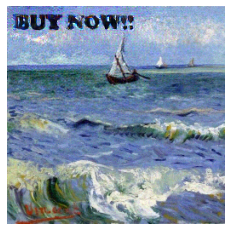

In [ ]:
mask = pil_load(mask_path)
inpainted_result = run(CRFILL, attack_img, mask)
plt.imshow(inpainted_result[0].permute(1, 2, 0).detach().cpu().numpy())
plt.axis("off")
plt.show()

In [ ]:
import json
res_j = json.dumps(res)
f = open("defences.json", "w")
f.write(res_j)
f.close()

****
Attacking multiple models, gradient visualisation

In [7]:
def requires_norm(j):
    return j in [0, 3, 4]
unnorm = lambda x: (x + 1) / 2

COLOUR_WEIGHT = 4.
epsilons = [0.15]

def malpaint(x_img, target_img, mask, TARGET_MODELS):
    global COLOUR_WEIGHT
    first_attack = None
    attack_images = []

    targ = transforms.ToTensor()(target_img).to(device)
    targ = transforms.Resize(img_shape[:-1])(targ)
    
    x = transforms.ToTensor()(x_img).to(device)
    x = transforms.Resize(img_shape[:-1])(x)
    x = transforms.CenterCrop(img_shape[:-1])(x)

    norm_x = normalise(x)

    target = (targ * mask + x * (1. - mask)).unsqueeze(0)
    norm_target = normalise(target.clone())

    # calculate gram matrices of style image (target in this case)
    with torch.no_grad():
        style_loss_features = loss_network(target)
        gram_style = [gram_matrix(y) for y in style_loss_features]

    for epsilon in epsilons:
        #x = pil_load(image_path)
        x = transforms.ToTensor()(x_img).to(device)
        x = transforms.Resize(img_shape[:-1])(x)
        x = transforms.CenterCrop(img_shape[:-1])(x)
        x = x.unsqueeze(dim=0)
        
        norm_x = normalise(x)

        _x = x.clone()
        _norm_x = norm_x.clone()

        iters = 500.0 if epsilon > 0.0 else 1.0
        step = epsilon / 100
        i = 0

        upper = torch.clamp(x + epsilon, min=0, max=1)
        lower = torch.clamp(x - epsilon, min=0, max=1)

        norm_upper = torch.clamp(norm_x + epsilon, min=-1, max=1)
        norm_lower = torch.clamp(norm_x - epsilon, min=-1, max=1)
        
        while i < iters:
            i += 1

            cumulative_datagrad = None
            for j in TARGET_MODELS:
                model = models[j]

                var_x = Variable(norm_x if requires_norm(j) else x, requires_grad=True)

                if var_x.grad is not None:
                    var_x.grad.data.zero_()

                var_x.retain_grad()
                run_preloaded = run_preloaded_m1to1 if requires_norm(j) else run_preloaded_0to1
                full_result = run_preloaded(j, model, var_x, mask)

                colour_loss = COLOUR_WEIGHT * F.mse_loss(full_result, norm_target if requires_norm(j) else target)

                # vgg visual loss
                # loss_network only operates on [0, 1] range
                features_full = loss_network(unnorm(full_result) if requires_norm(j) else full_result)
                features_input = loss_network(target)

                content_loss = CONTENT_WEIGHT * F.mse_loss(features_full[2], features_input[2])

                reg_loss = REGULARIZATION * (
                        torch.sum(torch.abs(full_result[:, :, :, :-1] - full_result[:, :, :, 1:])) + 
                        torch.sum(torch.abs(full_result[:, :, :-1, :] - full_result[:, :, 1:, :])))
                
                style_loss = 0.
                for l, weight in enumerate(STYLE_WEIGHTS):
                    gram_s = gram_style[l]
                    gram_y = gram_matrix(features_full[l])
                    style_loss += float(weight) * F.mse_loss(gram_y, gram_s.expand_as(gram_y))
                
                total_loss = content_loss + style_loss + reg_loss + colour_loss

                # if i % 30 == 0:
                #     print(i, total_loss)
                if type(model) is not tuple:
                    model.zero_grad()
                else:
                    for m in model:
                        m.zero_grad()
                total_loss.backward()

                # Collect datagrad
                data_grad = var_x.grad.data.sign() * step

                # Sum datagrads from models in loop
                if cumulative_datagrad is None:
                    cumulative_datagrad = data_grad
                else:
                    cumulative_datagrad += data_grad

            x = (x - (cumulative_datagrad[0] * (1 - mask)))
            x = torch.max(torch.min(x, upper), lower)
            norm_x = (norm_x - (cumulative_datagrad[0] * (1 - mask)))
            norm_x = torch.max(torch.min(norm_x, norm_upper), norm_lower)

            attack_img = x.clone().squeeze().permute(1, 2, 0).detach().cpu().numpy()
            if first_attack is None:
                first_attack = x.clone().squeeze().permute(1, 2, 0).detach().cpu().numpy()

        attack_images.append(attack_img)

    return attack_images, first_attack

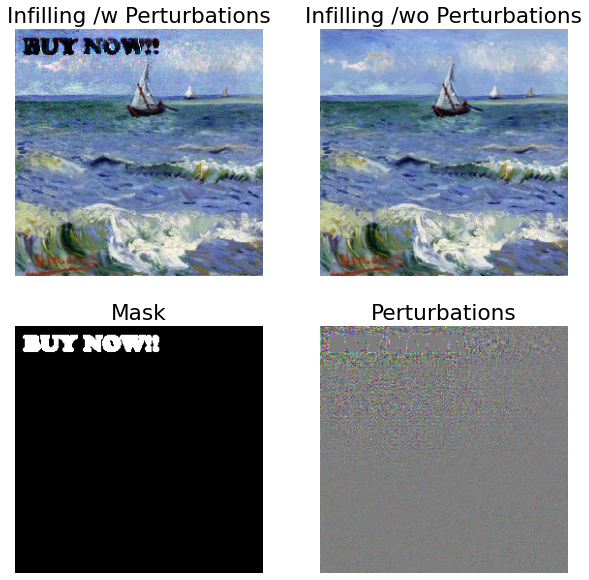

In [16]:
image_path = f"{DRIVE_ROOT}/results/watermark.png"
mask_path  = f"{DRIVE_ROOT}/results/watermark_mask.png" 
image_target_path = f"{DRIVE_ROOT}/results/watermark.png"

x = pil_load(image_path)
target = pil_load(image_target_path)

ATTACK = CRFILL
epsilons = [0.3]
run_preloaded = run_preloaded_m1to1

mask = transforms.ToTensor()(pil_load(mask_path))[0].unsqueeze(dim=0).to(device)
attack_imgs, _ = malpaint(x, target, mask, [ATTACK])

name_map = ["GENERATIVE", "RFR", "RN", "CRFILL", "GMCNN", "EDGE CONNECT", "Mask", "Target", "Adversarial"]
#plot_all(name_map, attack_imgs[0], pil_load(mask_path), target, image_path)

x = transforms.ToTensor()(attack_imgs[0]).to(device)
x = transforms.Resize(img_shape[:-1])(x)
x = transforms.CenterCrop(img_shape[:-1])(x)
x = x.unsqueeze(dim=0)
x = normalise(x)

img = run_preloaded(ATTACK, models[ATTACK], x, mask)

x = transforms.ToTensor()(pil_load(image_path)).to(device)
x = transforms.Resize(img_shape[:-1])(x)
x = transforms.CenterCrop(img_shape[:-1])(x)
x = x.unsqueeze(dim=0)
x = normalise(x)

img_clean = run_preloaded(ATTACK, models[ATTACK], x, mask)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
matplotlib.rcParams.update({'font.size': 18})
ax[0, 0].axis('off')
ax[0, 0].set_title("Infilling /w Perturbations")
ax[0, 0].imshow(unnorm(img).squeeze().permute(1, 2, 0).detach().cpu().numpy())

ax[0, 1].axis('off')
ax[0, 1].set_title("Infilling /wo Perturbations")
ax[0, 1].imshow(unnorm(img_clean).squeeze().permute(1, 2, 0).detach().cpu().numpy())

ax[1, 0].axis('off')
ax[1, 0].set_title("Mask")
ax[1,0].imshow(pil_load(mask_path))

ax[1,1].axis('off')
ax[1,1].set_title("Perturbations")
diff = unnorm(x).squeeze().permute(1, 2, 0).detach().cpu().numpy() - attack_imgs[0]
ax[1,1].imshow((diff - np.min(diff)) / (np.max(diff) - np.min(diff)))
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Model moved to cuda
initialize network with normal
loading the model from /content/drive/My Drive/papers/deepfill/pretrained/inpainting_gmcnn/celeba/10_net_GM.pth


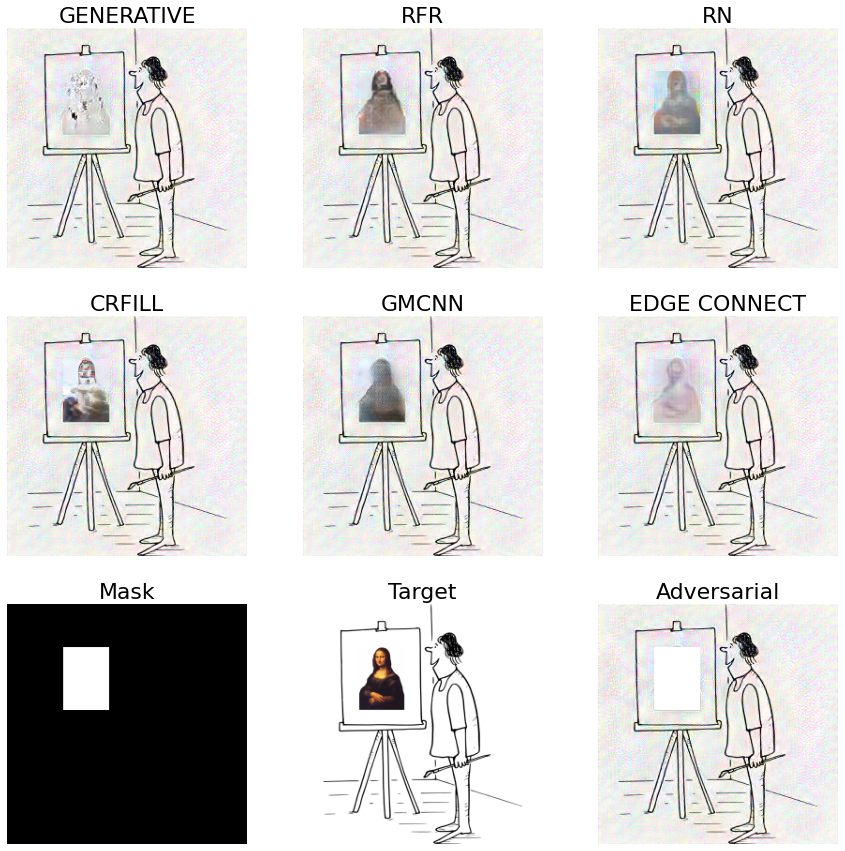

In [ ]:
image_path = f"{DRIVE_ROOT}/artist.png"
mask_path  = f"{DRIVE_ROOT}/artist_mask.png" 
image_target_path = f"{DRIVE_ROOT}/artist_target.png"

x = pil_load(image_path)
target = pil_load(image_target_path)

ATTACK = [0, 1, 2, 3, 4, 5]
epsilons = [0.2] #[0.0, 0.03, 0.05, 0.1, 0.2, 0.3]

mask = transforms.ToTensor()(pil_load(mask_path))[0].unsqueeze(dim=0).to(device)
attack_imgs, first_attack = malpaint(x, target, mask, ATTACK)

#fig = plt.figure(figsize=(18, 5))

#mask = pil_load(mask_path)
#for i in range(len(epsilons)):
#    ax = fig.add_subplot(2, len(epsilons), i + 1)
#    ax.set_title(f"$\\epsilon={epsilons[i]}$", fontdict={'fontsize': 22, 'fontweight': 'medium'})
#    ax.imshow(attack_imgs[i])
#    ax.axis('off')
#for i in range(6):
#    ax = fig.add_subplot(2, len(epsilons), i + len(epsilons) + 1)
#    #ax.set_title(f"$\\epsilon={epsilons[i]}$")
#    inpainted_result = run(ATTACK, attack_imgs[i], mask)
#    ax.imshow(inpainted_result.squeeze().permute(1, 2, 0).detach().cpu().numpy())
#    ax.axis('off')
#
#plt.show()

name_map = ["GENERATIVE", "RFR", "RN", "CRFILL", "GMCNN", "EDGE CONNECT", "Mask", "Target", "Adversarial"]
plot_all(name_map, attack_imgs[0], pil_load(mask_path), target, image_path)

#mask = pil_load(mask_path)
#inpainted_result = run(ATTACK, attack_imgs[0], mask)
#plt.imshow(inpainted_result[0].permute(1, 2, 0).detach().cpu().numpy())
#plt.axis("off")
#plt.show()

#inpainted_result = run(ATTACK, first_attack, mask)
#plt.imshow(inpainted_result[0].permute(1, 2, 0).detach().cpu().numpy())
#plt.axis("off")
#plt.show()

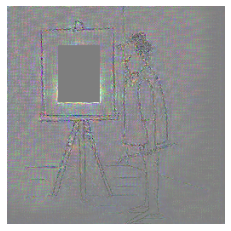

In [ ]:
x = transforms.ToTensor()(pil_load(image_path)).permute(1, 2, 0).numpy()
diff = x - attack_imgs[0]
plt.imshow((diff - np.min(diff)) / (np.max(diff) - np.min(diff)))
plt.axis("off")
plt.show()

In [ ]:
def requires_norm(j):
    return j in [0, 3, 4]
unnorm = lambda x: (x + 1) / 2
x = transforms.ToTensor()(pil_load(f"{DRIVE_ROOT}/squirrel.png")).to(device)
x = transforms.Resize(img_shape[:-1])(x)
x = transforms.CenterCrop(img_shape[:-1])(x)
x = x.unsqueeze(dim=0)
norm_x = normalise(x)

target = x.clone()
norm_target = norm_x.clone()

# calculate gram matrices of style image (target in this case)
with torch.no_grad():
    style_loss_features = loss_network(target)
    gram_style = [gram_matrix(y) for y in style_loss_features]

mask = transforms.ToTensor()(pil_load(f"{DRIVE_ROOT}/squirrel_mask.png"))[0].unsqueeze(dim=0).to(device)

j = EDGE_CONNECT
var_x = Variable(norm_x if requires_norm(j) else x, requires_grad=True)

model = models[j]
if var_x.grad is not None:
    var_x.grad.data.zero_()

var_x.retain_grad()
run_preloaded = run_preloaded_m1to1 if requires_norm(j) else run_preloaded_0to1
full_result = run_preloaded(j, model, var_x, mask)

colour_loss = 4. * F.mse_loss(full_result, norm_target if requires_norm(j) else target)

# vgg visual loss
# loss_network only operates on [0, 1] range
features_full = loss_network(unnorm(full_result) if requires_norm(j) else full_result)
features_input = loss_network(target)

content_loss = CONTENT_WEIGHT * F.mse_loss(features_full[2], features_input[2])

reg_loss = REGULARIZATION * (
        torch.sum(torch.abs(full_result[:, :, :, :-1] - full_result[:, :, :, 1:])) + 
        torch.sum(torch.abs(full_result[:, :, :-1, :] - full_result[:, :, 1:, :])))

style_loss = 0.
for l, weight in enumerate(STYLE_WEIGHTS):
    gram_s = gram_style[l]
    gram_y = gram_matrix(features_full[l])
    style_loss += float(weight) * F.mse_loss(gram_y, gram_s.expand_as(gram_y))

total_loss = content_loss + style_loss + reg_loss + colour_loss

# if i % 30 == 0:
#     print(i, total_loss)
if type(model) is not tuple:
    model.zero_grad()
else:
    for m in model:
        m.zero_grad()
total_loss.backward()

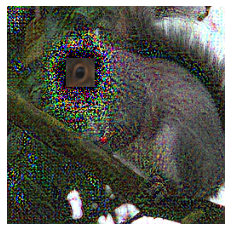

In [ ]:
grad_np = var_x.grad.data[0].permute(1, 2, 0).cpu().numpy()
x_np = np.array(pil_load(f"{DRIVE_ROOT}/squirrel.png")) / 255

grad_np_ = (grad_np - np.min(grad_np)) / (np.max(grad_np) - np.min(grad_np))
grad_np_ = np.abs(grad_np_ - 0.5) * 75

#plt.imshow(grad_np_)
plt.imshow(np.clip(x_np + (1 - grad_np_), 0, 1))
plt.axis('off')
#plt.imshow((grad_np - np.min(grad_np)) / (np.max(grad_np) - np.min(grad_np)))
plt.show()

****
Old Code

In [ ]:
import random 
def psnr(img1, img2):
  mse = torch.mean((img1 - img2) ** 2)
  return 10 * torch.log10(1 / mse)

image_path = f"{DRIVE_ROOT}/generative-inpainting-pytorch/examples/imagenet/imagenet_patches_ILSVRC2012_val_00045643_output.png"
image_target_path = f"{DRIVE_ROOT}/generative-inpainting-pytorch/examples/nsa.png"
# image_target_path = f"{DRIVE_ROOT}/generative-inpainting-pytorch/examples/digits.png"

targ = pil_load(image_target_path)
target = transforms.ToTensor()(targ).to(device)
_target = transforms.Resize(img_shape[:-1])(target)
_norm_target = normalise(_target.clone())

x = pil_load(image_path)
#mask = pil_load(mask_path)

x = transforms.ToTensor()(x).to(device)
x = transforms.Resize(img_shape[:-1])(x)
x = transforms.CenterCrop(img_shape[:-1])(x)
x = x.unsqueeze(dim=0)
#mask = transforms.ToTensor()(mask)[0].unsqueeze(dim=0).to(device)

norm_x = normalise(x.clone())

iters = 3000.0
epsilon = 0.03
step = epsilon / 30
update_freq = 1
log_freq = 50

i = 0
num_masks = 15

unnorm = lambda x: (x + 1) / 2

# work out clamping limit
upper = torch.clamp(x + epsilon, min=0, max=1)
lower = torch.clamp(x - epsilon, min=0, max=1)
norm_upper = torch.clamp(norm_x + epsilon, min=-1, max=1)
norm_lower = torch.clamp(norm_x - epsilon, min=-1, max=1)

print("Target", target.min(), target.max())
print("x", x.min(), x.max())
# plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
# plt.show()

masks = []
for _ in range(num_masks):
  mask = torch.zeros([1]+img_shape[:-1])
  mask = transforms.RandomErasing(p=1, scale=(0.01, 0.1), value=1)(mask)
  mask = mask.to(device)

  masks.append(mask)

def requires_norm(j):
    return j == 0 or j == 3

# var_x = Variable(x, requires_grad=True)
# optimizer = torch.optim.Adam([var_x], lr=0.1, betas=(0.9, 0.99))
        
logs = []
while i < iters:
    # generate random mask
    if (i % update_freq) == 0:
      
      mask = random.choice(masks)

      # apply perturbation
      target = _target.clone() * mask + x.squeeze(0)*(1-mask)
      norm_target = _norm_target.clone() * mask + norm_x.squeeze(0)

      target = target.unsqueeze(0)

      # print("New target")
      # img = target[0].permute(1, 2, 0).detach().cpu().numpy()
      # plt.imshow(img)
      # plt.show()

      norm_target = norm_target.unsqueeze(0)
    
    i += 1
    # apply FGSM
    cumulative_datagrad = None
    # change order to pick which model's datagrad to use
    for j in [3]: # [3, 1, 2, 0]:
        model = models[j]
        
        val = (norm_x if requires_norm(j) else x)
        var_x.data = val.data

        # optimizer.zero_grad()

        if var_x.grad is not None:
            var_x.grad.data.zero_()

        var_x.retain_grad()
        
        run_preloaded = run_preloaded_m1to1 if requires_norm(j) else run_preloaded_0to1

        full_result = run_preloaded(j, model, var_x, mask)

        # f = F.mse_loss
        # f = F.l1_loss
        f = lambda __x, __y: F.mse_loss(__x, __y)# + psnr(__x, __y)#ssim(_x, _y, data_range=1)

        loss = f(full_result, norm_target if requires_norm(j) else target)
        model.zero_grad()
        loss.backward()
        
        # optimizer.step()
        logs.append(float(loss))
        if (i % log_freq) == 0:
          print(np.mean(logs), "+-", np.std(logs))
          logs = []

        # Collect datagrad
        data_grad = var_x.grad.data.sign() * torch.cuda.FloatTensor(*(var_x.grad.data.shape)).uniform_() * step

        # Sum datagrads from all the papers
        # if cumulative_datagrad is None:
        cumulative_datagrad = data_grad
        # else:
        #     cumulative_datagrad += data_grad

        # work out augmented perturbation
        x = x - (cumulative_datagrad[0] * (1 - mask))
        x = torch.max(torch.min(x, upper), lower)

        norm_x = norm_x - (cumulative_datagrad[0] * (1 - mask))
        norm_x = torch.max(torch.min(norm_x, norm_upper), norm_lower)
    
    attack_img = x.clone().squeeze().permute(1, 2, 0).detach().cpu().numpy()
    #attack_img = unnorm(norm_x).clone().squeeze().permute(1, 2, 0).detach().cpu().numpy()
    
    #print("----")
print("Final Attack Image")
plt.imshow(attack_img)
plt.show()